# Genre Prediction Based on Lyrics

## Introduzione
La relazione si pone l'obiettivo di definire un predittore di genere musicale basato su lyrics (testi delle canzoni). Il dataset utilizzato è una istanza di https://tmthyjames.github.io/2018/january/Cypher/ (Cypher, https://github.com/tmthyjames/cypher). Il progetto è attualmente dismesso, ma è possibile reperire in rete alcune istanze (tipicamente da altri progetti github). Il dataset consiste in un documento in formato CSV in cui sono presenti informazioni riguardo brani musicali di vari generi: titolo, cantante, album, genere, etc. ... Su tale dataset si sviluppa l'allenamento del modello di machine learning ed i relativi test di verifica dell'apprendimento. Una volta allenata la rete neurale si proveranno ad affettuare una serie di predizioni con nuovi brani e verranno verificati i risultati.

Contenuto
- Caricamento dei Dati
- Pre-processamento dei dati
- Allenamento del Modello
- Visualizzazione dei risultati

#### Prerequisiti
Una lista di librerie necessarie al corretto funzionamento del notebook:
- pandas
- numpy
- sklearn
- random

## Caricamento dei Dati
Per caricare i dati in formato csv all'interno del programma viene utilizzato pandas, in particolare il metodo __read_csv__ creando un *dataframe*. Ai fini di poter raggruppare alcuni dei sottogeneri o derivati del genere rock è stato creato un alias chiamato _alt rock_ che raggruppa: screamo, punk rock ed heavy metal.

Motivazione di rankergenre --> praticamente genre è una serie e quindi è un po' un casino gestirla, allora è presente una colonna che identifica solamente un genere per canzone e questo viene usato per selezionare correttamente le canzoni. Magari posso anche provare a rinominare una colonna e bona così smetto di avere queste beghe e buonanotte. 
TO DO: elimina genre column e rimonomina ranker to genre.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Read in the CSV file and filter the data to include only rows with 'screamo', 'punk rock', or 'heavy metal' in the 'genre' column
df = pd.read_csv('lyrics.csv', on_bad_lines='skip')
df['ranker_genre'] = np.where(
    (df['ranker_genre'] == 'screamo')|
    (df['ranker_genre'] == 'punk rock')|
    (df['ranker_genre'] == 'heavy metal'), 
    'alt rock', 
    df['ranker_genre']
)

/tmp/ipykernel_566462/1331866022.py:12: DtypeWarning: Columns (2,5,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('lyrics.csv', on_bad_lines='skip')


Si procede con il raggruppamento sui seguenti campi: _song_, _year_, _album_, _genre_, _artist_, *ranker_genre*. Si applicano poi vari metodi che anticipano la seguente fase di preprocessing sui titoli delle canzoni, andando ad effettuare il lowering (transformazione da caratteri in maiuscolo in minuscolo), rimozione di caratteri non necessari e operazioni di _join_ su spazi bianchi.

In [2]:
# Group the data by song, year, album, genre, artist, and ranker_genre, and concatenate the lyrics into a single string for each group
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
lyrics_by_song = df.sort_values(group)\
        .groupby(group).lyric\
        .apply(' '.join)\
        .apply(lambda x: x.lower())\
        .reset_index(name='lyric')

# Remove non-alphanumeric characters from the 'lyric' column
lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')


/tmp/ipykernel_566462/1107819266.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')


## Creazione dei dataset
In questa relazione si prendono in considerazione 3 generi: pop, alternative rock (alt rock) e hip hop. Si definiscono dei paremetri relativi alla ricerca di canzoni per questi generi come:
- numero di caratteri che deve avere ogni canzone per poter essere considerata
- numero di canzoni  

Vengono infine creati due dataset: uno di traning e uno di test, che verranno utilizzati per allenare il modello ed effettuare i test finali.

In [3]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import random

# select genre to analyze
genres = [
    'pop', 'alt rock', 'Hip Hop',
]

LYRIC_LEN = 400 # each song has to be > 400 characters
N = 1000
RANDOM_SEED = 200 # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()

# loop over each genre
for gen in genres: 
    # create a subset with the correct genre and the right lenght of the song
    subset = lyrics_by_song[  
        (lyrics_by_song.ranker_genre==gen) & 
        (lyrics_by_song.lyric.str.len() > LYRIC_LEN)
    ]
    
    # dataset creation
    train_set = subset.sample(n=N, random_state=RANDOM_SEED, replace=True)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set) # append subsets to the master sets
    test_df = test_df.append(test_set)

train_df = shuffle(train_df)
test_df = shuffle(test_df)

/tmp/ipykernel_566462/2689487206.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_566462/2689487206.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_566462/2689487206.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_566462/2689487206.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_566462/2689487206.py:28: FutureWarning: The frame.append method is 

Con i dataset appena creati possiamo creare due pipelines che ci forniscono due implementazione diverse del metodo NaiveBayes: nel primo caso implementiamo __CountVectorizer__ e nel secondo __TfidfVectorizer__. Il primo implementa funzionalità di analisi di frequenza dei termini all'interno delle lyrics, mentre il secondo si basa su *Term Frequency - Inverse Document Frequency*. Tale valore aumenta proporzionalmente al numero di volte che il termine è contenuto nel documento, ma cresce in maniera inversamente proporzionale con la frequenza del termine nella collezione. L'idea alla base di questo comportamento è di dare più importanza ai termini che compaiono nel documento, ma che in generale sono poco frequenti.

All'interno delle pipelines sono inoltre presenti dei parametri che ci permettono di effetuare operazione di pre-processing sui dati quali: 
- rimozion di *stopwords*
- lemmatization

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

stop = list(set(stopwords.words('english'))) # stopwords
wnl = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) == 2 and w.isalnum() # only words that are  2 characters
    )                                  # and is alpha-numeric


# Define a function to create a pipeline with a count vectorizer and a Multinomial Naive Bayes classifier
count_nb_pipeline = Pipeline([
        ('vect', CountVectorizer(       
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents)),
        ('clf', MultinomialNB(alpha=0.1))
    ])

# Define a function to create a pipeline with a Tf-idf vectorizer and a Multinomial Naive Bayes classifier
tfidf_nb_pipeline = Pipeline([
        ('vect', TfidfVectorizer(
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
        ('clf', MultinomialNB(alpha=0.1))
    ])

# Use cross-validation to evaluate the performance of the count vectorizer/Multinomial NB pipeline
scores = cross_val_score(count_nb_pipeline, train_df.lyric, train_df.ranker_genre, cv=5)
print(f"Mean count vectorizer/Multinomial NB accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

# Use cross-validation to evaluate the performance of the Tf-idf vectorizer/Multinomial NB pipeline
scores = cross_val_score(tfidf_nb_pipeline, train_df.lyric, train_df.ranker_genre, cv=5)
print(f"Mean Tf-idf vectorizer/Multinomial NB accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")

# Define a parameter grid for the count vectorizer/Multinomial NB pipeline
param_grid = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [2, 3, 4],
    'vect__max_features': [None, 1000, 5000],
    'clf__alpha': [0.1, 0.5, 1.0]
}

# Use grid search to tune the hyperparameters of the count vector
# Use randomized search to tune the hyperparameters of the count vectorizer/Multinomial NB pipeline
random_search_count_nb_pipeline = RandomizedSearchCV(count_nb_pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=RANDOM_SEED)
random_search_count_nb_pipeline.fit(train_df.lyric, train_df.ranker_genre)
print(f"Best count vectorizer/Multinomial NB accuracy: {random_search_count_nb_pipeline.best_score_:.3f}")
print(f"Best count vectorizer/Multinomial NB parameters: {random_search_count_nb_pipeline.best_params_}")

# Use randomized search to tune the hyperparameters of the Tf-idf vectorizer/Multinomial NB pipeline
random_search_tfidf_nb_pipeline = RandomizedSearchCV(tfidf_nb_pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=RANDOM_SEED)
random_search_tfidf_nb_pipeline.fit(train_df.lyric, train_df.ranker_genre)
print(f"Best Tf-idf vectorizer/Multinomial NB accuracy: {random_search_tfidf_nb_pipeline.best_score_:.3f}")
print(f"Best Tf-idf vectorizer/Multinomial NB parameters: {random_search_tfidf_nb_pipeline.best_params_}")

Mean count vectorizer/Multinomial NB accuracy: 0.543 +/- 0.009
Mean Tf-idf vectorizer/Multinomial NB accuracy: 0.561 +/- 0.015
Best count vectorizer/Multinomial NB accuracy: 0.588
Best count vectorizer/Multinomial NB parameters: {'vect__min_df': 2, 'vect__max_features': None, 'vect__max_df': 0.5, 'clf__alpha': 0.1}
Best Tf-idf vectorizer/Multinomial NB accuracy: 0.600
Best Tf-idf vectorizer/Multinomial NB parameters: {'vect__min_df': 3, 'vect__max_features': None, 'vect__max_df': 0.75, 'clf__alpha': 0.1}


## Visualizzazione dei risultati

Con i risultati ottenuti è possibile andare a comporre una matrice di confusione per poter andare a visualizzare i risultati ottenuti in maniera grafica. Questo permette di valutare in che campi le previsioni del modello tendono a sbagliare e confondere un genere per un altro.

Text(113.9222222222222, 0.5, 'predicted label count_nb pipeline')

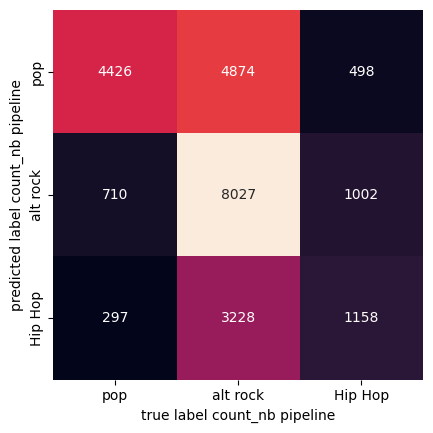

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# score our model on testing data
predicted = random_search_count_nb_pipeline.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label count_nb pipeline')
plt.ylabel('predicted label count_nb pipeline')

Text(113.9222222222222, 0.5, 'predicted label tfidf_nb pipeline')

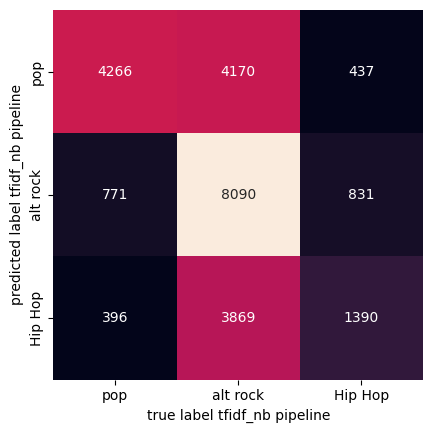

In [59]:
predicted = random_search_tfidf_nb_pipeline.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label tfidf_nb pipeline')
plt.ylabel('predicted label tfidf_nb pipeline')

Per concludere si rimanda in calce ai risultati relativi a:
1. Precision: capacità di classificazione corretta degli elementi dell'insieme che sta venendo considerato;
2. Recall: capacità di ottenimento di tutti gli elementi interessanti al fine dell'analisi;
3. Fscore: misura di accuratezza basata dalla combinazione di *precision* e *recall*;



In [60]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

POP_precision: 0.4807844021187873
POP_recall: 0.7852015461071231
POP_fscore: 0.5963931217670907
POP_support: 5433

ALT ROCK_precision: 0.8347090383821708
ALT ROCK_recall: 0.5015810031620064
ALT ROCK_fscore: 0.6266217419929515
ALT ROCK_support: 16129

HIP HOP_precision: 0.2458001768346596
HIP HOP_recall: 0.5229495861550038
HIP HOP_fscore: 0.33441597497894865
HIP HOP_support: 2658



## Implemntazione con Tensor Flow

2023-01-14 19:18:15.023069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 19:18:15.383837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 19:18:15.383868: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-14 19:18:16.562322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/10
94/94 [==============================] - 10s 105ms/step - loss: 0.5387 - accuracy: 0.7730 - val_loss: 0.4957 - val_accuracy: 0.8082
Epoch 2/10
94/94 [==============================] - 12s 124ms/step - loss: 0.1219 - accuracy: 0.9663 - val_loss: 0.5441 - val_accuracy: 0.8012
Epoch 3/10
94/94 [==============================] - 10s 111ms/step - loss: 0.0339 - accuracy: 0.9973 - val_loss: 0.6006 - val_accuracy: 0.8042
Epoch 4/10
94/94 [==============================] - 9s 102ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.6396 - val_accuracy: 0.8099
Epoch 5/10
94/94 [==============================] - 12s 127ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.6893 - val_accuracy: 0.8071
Epoch 6/10
94/94 [==============================] - 10s 107ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7448 - val_accuracy: 0.8004
Epoch 7/10
94/94 [==============================] - 12s 125ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7399 - val_accuracy: 0.8112


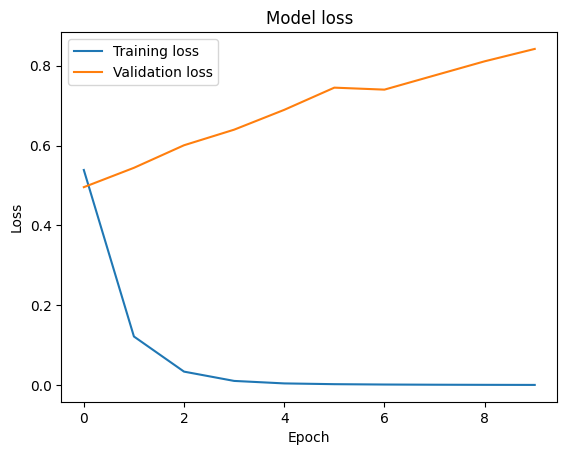

757/757 [==============================] - 5s 6ms/step
Accuracy for alt rock: 0.78
Accuracy for Hip Hop: 0.88
Accuracy for pop: 0.74


In [4]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense
import random

# Encode the labels as integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_df.ranker_genre)
y_test = encoder.transform(test_df.ranker_genre)

# Vectorize the lyrics
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df.lyric)
X_test = vectorizer.transform(test_df.lyric)

model = tf.keras.Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

# Convert the vectors to a dense tensor
X_train = tf.convert_to_tensor(X_train.todense())
X_test = tf.convert_to_tensor(X_test.todense())


history = model.fit(X_train, y_train_tensor, epochs=10, validation_data=(X_test, y_test_tensor))

# display the data
import matplotlib.pyplot as plt

# Get the training and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

# Get the predicted class probabilities for each sample in the test set
probs = model.predict(X_test)

# Initialize a dictionary to store the accuracy for each genre
genre_accuracy = {}

# Loop over the test samples
for i, sample in enumerate(X_test):

    # Get the true class for the sample
    true_class = y_test[i]

    # Get the predicted class for the sample
    predicted_class = np.argmax(probs[i])

    # Get the genre name for the true and predicted classes
    true_genre = encoder.inverse_transform([true_class])[0]
    predicted_genre = encoder.inverse_transform([predicted_class])[0]

    # Update the accuracy for the true genre
    if true_genre not in genre_accuracy:
        genre_accuracy[true_genre] = 1 if true_genre == predicted_genre else 0
    else:
        genre_accuracy[true_genre] += 1 if true_genre == predicted_genre else 0

# Divide the number of correctly predicted samples by the total number of samples for each genre to get the accuracy
for genre, count in genre_accuracy.items():
    genre_accuracy[genre] = count / test_df[test_df.ranker_genre == genre].shape[0]

# Print the accuracy for each genre
for genre, accuracy in genre_accuracy.items():
    print(f'Accuracy for {genre}: {accuracy:.2f}')
